In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
np.set_printoptions(precision=2)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Since version 3.1 PyMC3 has a GP module and many examples showing how to use it. Please check the PyMC3 documentation http://docs.pymc.io/gp.html

## Kernelized Regression

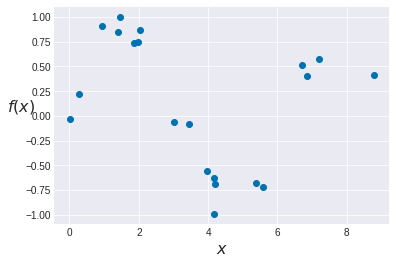

In [2]:
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_01.png', dpi=300, figsize=[5.5, 5.5])

In [3]:
def gauss_kernel(x, n_knots):
    """
    Simple Gaussian radial kernel
    """
    knots = np.linspace(x.min(), x.max(), n_knots)    
    w = 2 
    return np.array([np.exp(-(x-k)**2/w) for k in knots])

In [4]:
n_knots = 5

In [5]:
with pm.Model() as kernel_model:
    gamma = pm.Cauchy('gamma', alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform('sd',0,  10)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    yl = pm.Normal('yl', mu=mu, sd=sd, observed=y)
    #kernel_trace = pm.sample(10000, step=pm.Metropolis())
    kernel_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_interval__, gamma]
100%|██████████| 1500/1500 [00:01<00:00, 750.80it/s]


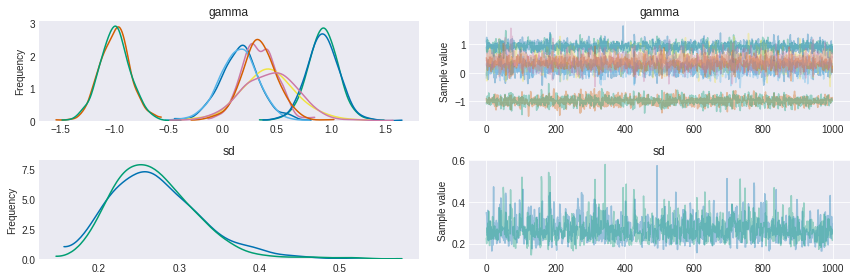

In [6]:
pm.traceplot(kernel_trace);
plt.savefig('B04958_08_02.png', dpi=300, figsize=[5.5, 5.5])

In [7]:
pm.summary(kernel_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
gamma__0,0.150937,0.181770,0.003991,-0.242939,0.480314,2137.579975,1.001207
gamma__1,0.923073,0.145618,0.003620,0.630789,1.198292,1984.557281,0.999519
gamma__2,-0.996889,0.139879,0.002742,-1.304094,-0.748117,2186.325852,0.999550
gamma__3,0.336178,0.164128,0.003985,0.024384,0.665999,1603.076836,0.999504
gamma__4,0.426703,0.259267,0.006342,-0.099667,0.916103,1818.175416,0.999656
sd,0.271261,0.056383,0.001511,0.171516,0.376869,1230.485331,0.999593


100%|██████████| 100/100 [00:00<00:00, 1115.86it/s]


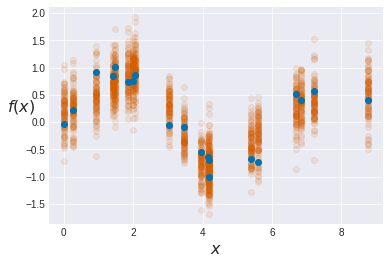

In [8]:
ppc = pm.sample_ppc(kernel_trace, model=kernel_model, samples=100)

plt.plot(x, ppc['yl'].T, 'C2o', alpha=0.1)

plt.plot(x, y, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_03.png', dpi=300, figsize=[5.5, 5.5])

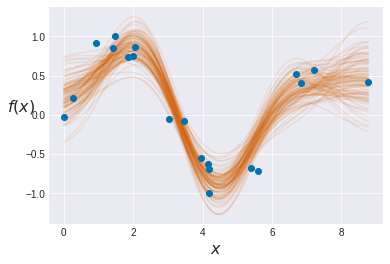

In [9]:
new_x = np.linspace(x.min(), x.max(), 100)
k = gauss_kernel(new_x, n_knots)
gamma_pred = kernel_trace['gamma']
for i in range(100):
    idx = np.random.randint(0, len(gamma_pred))
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(new_x, y_pred, 'C2-', alpha=0.1)
plt.plot(x, y, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_04.png', dpi=300, figsize=[5.5, 5.5])

## Gaussian Processes

In [10]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])

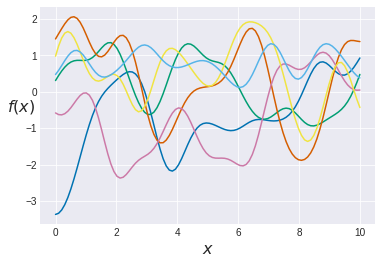

In [11]:
np.random.seed(1)
test_points = np.linspace(0, 10, 100)
cov = np.exp(-squared_distance(test_points, test_points))
plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_05.png', dpi=300, figsize=[5.5, 5.5]);

/home/osvaldo/anaconda3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:651: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


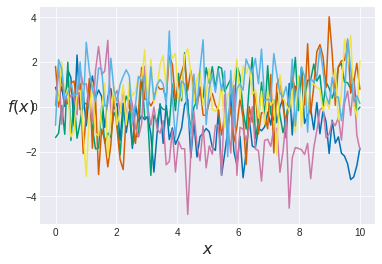

In [12]:
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03
D = squared_distance(test_points, test_points)

cov = eta * np.exp(-rho * D)
diag = eta * sigma

np.fill_diagonal(cov, diag)

for i in range(6):
    plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_06.png', dpi=300, figsize=[5.5, 5.5]);

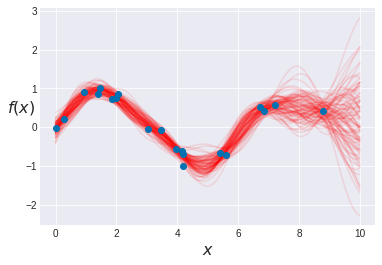

In [13]:
np.random.seed(1)

K_oo = eta * np.exp(-rho * D) 

D_x = squared_distance(x, x)
K = eta * np.exp(-rho * D_x)
diag_x = eta + sigma
np.fill_diagonal(K, diag_x)

D_off_diag = squared_distance(x, test_points)
K_o = eta * np.exp(-rho * D_off_diag)

# Posterior mean
mu_post = np.dot(np.dot(K_o, np.linalg.inv(K)), y)
# Posterior covariance
SIGMA_post = K_oo - np.dot(np.dot(K_o, np.linalg.inv(K)), K_o.T)


for i in range(100):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.plot(test_points, fx, 'r-', alpha=0.1)

plt.plot(x, y, 'o')
 
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_07.png', dpi=300, figsize=[5.5, 5.5]);

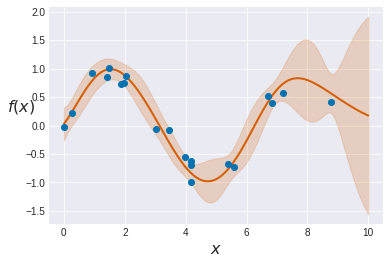

In [14]:
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(x).flatten()

# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2 * np.dot(a, b.T)
    return eta * np.exp(- rho * sqdist)

N = 20         # number of training points.
n = 100         # number of test points.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(0, 10, size=(N,1))
yfx = f(X) + sigma * np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + sigma * np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(0, 10, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, yfx))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
sd_pred = (np.diag(K_) - np.sum(Lk**2, axis=0))**0.5


plt.fill_between(Xtest.flat, mu - 2 * sd_pred, mu + 2 * sd_pred, color='C2', alpha=0.2)
plt.plot(Xtest, mu, 'C2', lw=2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_08.png', dpi=300, figsize=[5.5, 5.5]);

In [15]:
with pm.Model() as GP:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    D = squared_distance(x, x)
    
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * D), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(0, 10, 100)
    D_pred = squared_distance(test_points, test_points)
    D_off_diag = squared_distance(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SIGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    #start = pm.find_MAP()
    #trace = pm.sample(1000, start=start)
    
    trace = pm.sample(1000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, rho_log__, eta_log__]
100%|██████████| 1500/1500 [00:07<00:00, 189.49it/s]


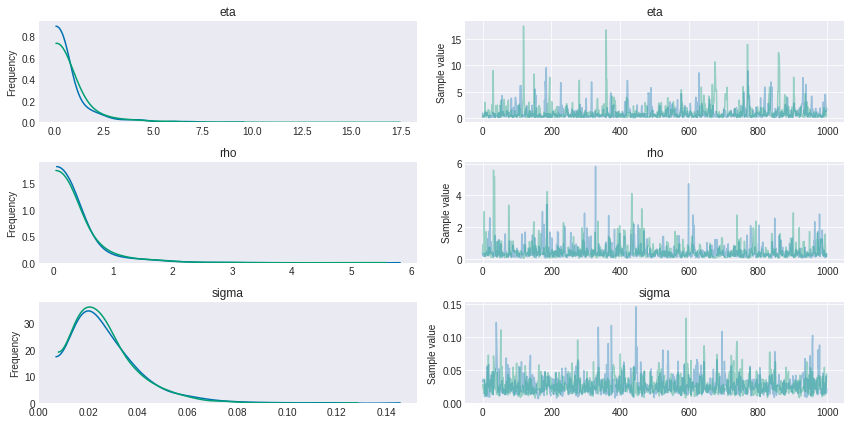

In [16]:
varnames = ['eta', 'rho', 'sigma']
pm.traceplot(trace, varnames)
plt.savefig('B04958_08_09.png', dpi=300, figsize=[5.5, 5.5]);

In [17]:
pm.summary(trace, varnames).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta,1.1350,1.4778,0.0546,0.0882,3.9558,622.1877,1.0006
rho,0.4726,0.5233,0.0166,0.0458,1.4362,871.7524,1.0001
sigma,0.0278,0.0145,0.0005,0.0088,0.0558,930.5297,1.0001


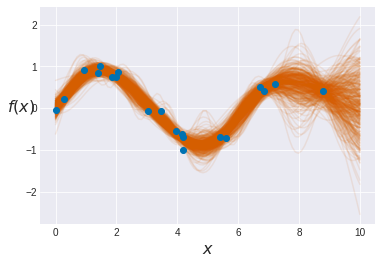

In [18]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in 
          zip(trace['mu_post'][::5], trace['SIGMA_post'][::5])]

for yp in y_pred:
    plt.plot(test_points, yp, 'C2-', alpha=0.1)

plt.plot(x, y, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_10.png', dpi=300, figsize=[5.5, 5.5]);

# Periodic Kernel

In [19]:
periodic = lambda x, y: np.array([[np.sin((x[i] - y[j])/2)**2 for i in range(len(x))] for j in range(len(y))])

In [20]:
with pm.Model() as GP_periodic:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    P = periodic(x, x)
    
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * P), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(0, 10, 100)
    D_pred = periodic(test_points, test_points)
    D_off_diag = periodic(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SIGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    #start = pm.find_MAP()
    #trace = pm.sample(1000, start=start)
    trace = pm.sample(1000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, rho_log__, eta_log__]
100%|██████████| 1500/1500 [00:08<00:00, 172.52it/s]


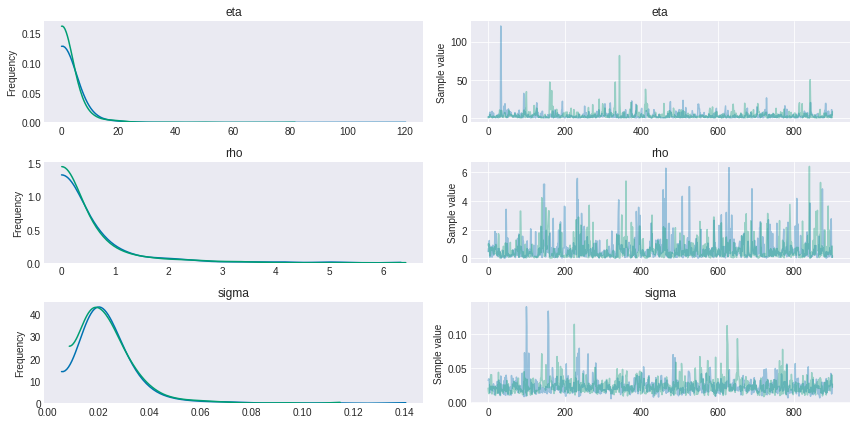

In [21]:
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.traceplot(chain, varnames);

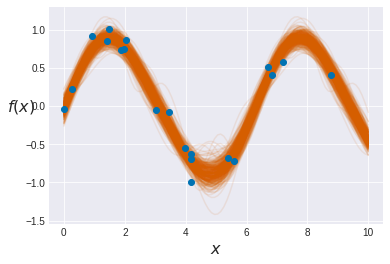

In [22]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]

for yp in y_pred:
    plt.plot(test_points, yp, 'C2-', alpha=0.1)

plt.plot(x, y, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.savefig('B04958_08_11.png', dpi=300, figsize=[5.5, 5.5]);

In [23]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nPandas %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, pd.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a computer x86_64 running debian stretch/sid and using:
Python 3.6.3
IPython 6.2.1
PyMC3 3.3
NumPy 1.14.1
SciPy 1.0.0
Pandas 0.22.0
Matplotlib 2.1.2
Seaborn 0.8.1

